In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

from ccvae import CCVAE 
from networks import Encoder, Decoder
from utils import run_ccvae, var_interv
from visualize import visualize_latent

### Initialize a model

In [2]:
z_dim = 10
num_classes = 3
use_cuda = 1
prior_p = torch.tensor([0.5, 0.5, 0.5]) # (label_i == 1).sum() / len(label_i)
drop_rate = 0.0
beta = 1.
alpha = 1.

In [3]:
encoder = Encoder(z_dim) # input: 1 x 64 x 64 image
decoder = Decoder(z_dim)

cc_vae = CCVAE(encoder, decoder, z_dim, num_classes,
              use_cuda, prior_p, drop_rate, beta, alpha)

# empir
optim = torch.optim.AdamW(params=[    
    {'params': list(cc_vae.encoder.parameters()) + list(cc_vae.decoder.parameters())},
    {'params': cc_vae.classifier.parameters(), 'lr': 1e-4},
    {'params': cc_vae.cond_prior.parameters(), 'lr': 1e-2}], lr=1e-4)

### Create dataset (random)

In [4]:
n_points = 100
train_points = 80
dataset = []

for _ in range(n_points):
    x = torch.randn(1,64,64).cuda()
    y = (torch.rand(3) > 0.5).float().cuda()
    dataset.append([x,y])
    
train_loader = DataLoader(dataset[:train_points], batch_size=32)
test_loader = DataLoader(dataset[train_points:], batch_size=32)

### Train the model

In [5]:
run_ccvae(cc_vae, optim, train_loader, test_loader, n_epochs = 10, verbose = True)

Epoch: 0, Training accuracy: 0.18, Testing accuracy: 0.08
Epoch: 1, Training accuracy: 0.16, Testing accuracy: 0.17
Epoch: 2, Training accuracy: 0.11, Testing accuracy: 0.10
Epoch: 3, Training accuracy: 0.15, Testing accuracy: 0.11
Epoch: 4, Training accuracy: 0.11, Testing accuracy: 0.07
Epoch: 5, Training accuracy: 0.19, Testing accuracy: 0.05
Epoch: 6, Training accuracy: 0.29, Testing accuracy: 0.11
Epoch: 7, Training accuracy: 0.26, Testing accuracy: 0.15
Epoch: 8, Training accuracy: 0.24, Testing accuracy: 0.10
Epoch: 9, Training accuracy: 0.27, Testing accuracy: 0.11


### Visualize latent space

In [6]:
xs, ys = next(iter(test_loader))

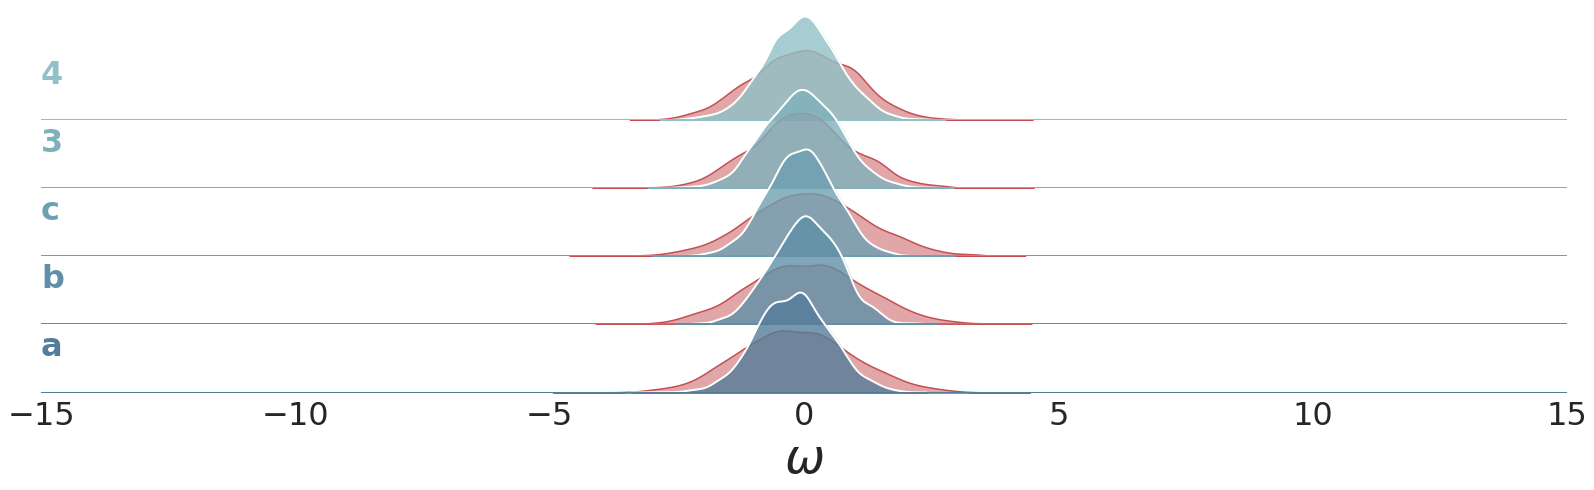

In [7]:
visualize_latent(cc_vae, xs, ys, ['a', 'b', 'c'], k = 100, n_priors = 5)

### Intervention analysis

In [8]:
label_values = torch.tensor([1,0,0]) # default values of labels (fixing dimensions)
ind_to_vary = 0 # index of the label which is to be intervened upon
n_interventions = 1000

In [9]:
var_X = var_interv(cc_vae, label_values, ind_to_vary, 'cuda').cpu().detach()

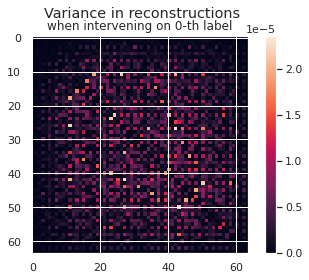

In [10]:
sns.set_theme()

plt.imshow(var_X)
plt.colorbar()
plt.suptitle('Variance in reconstructions')
plt.title(f'when intervening on {ind_to_vary}-th label');